## This scripts is about the data analysis of single subject demostration. The generated results were used for Fig3 and Fig3 related supplementary figures. It aims to show the parameters trained from HMM, and what information we learnt from this generative model

In [30]:
import numpy as np
import nilearn
from nilearn import plotting
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker, NiftiMapsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn import datasets
import nibabel
import scipy
import re
import pickle
import hmmlearn
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
from datetime import date
import time
import os
import itertools
import argparse
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from utils import *
import pandas as pd
from scipy.stats import ttest_ind, pearsonr
from statannot import add_stat_annotation
import plotly.express as px

# Data Loading

In [31]:
#pre defined terms
tmp_dir = "/Users/enningyang/Documents/forrest_project/tmp_data" # the folder to store intermediate results
c_names_dict = np.load(f"{tmp_dir}/c_names_dict.npy", allow_pickle=True).item()
yeo7_color = np.load(f"{tmp_dir}/yeo7_color.npy", allow_pickle=True).item() # the seven color used in original paper
haNames = list(np.load(f"{tmp_dir}/hippoAmygNames.npy")) # the names for hippo and amyg subregions
hippoNames = haNames[:19]
amygNames = haNames[19:]
annotations = pickle.load(open(f"{tmp_dir}/annotations.pickle", "rb")) # 52 human curated annotations
annotations_keys = list(annotations.keys())
n_pcs_dict = {'hippo':6, 'amyg':6}
subjects = np.load(f'{tmp_dir}/subjects.pickle',allow_pickle=1) # subject index
save_fig=0 # wether to save model or not
path_to_raw_hmm_models = '/Users/enningyang/Documents/forrest_project'

In [32]:
#gather the wanted models
key = 'final' 

# you can add more filters to select the exact set of models. e.g. "subject_01", "Default"
filter_words = [key,'subject_01','sub_nmf','n200']
args_list = list(set(np.load(f"{tmp_dir}/hmmlearn_args_list.npy")))
for i in filter_words:
    args_list = filter_args(i, args_list)    
args_list = np.unique(args_list)
args_list = [i.replace('/home/enning/scratch/forrest',path_to_raw_hmm_models) for i in args_list]

In [33]:
#load the models 
state_p_dict = {} #state presence
cora_dict = {} #correlation with annotations
cort_dict = {} #correlation with semantic components
HMMs_dict = {} #hmm models
for i, a in enumerate(args_list):
    try:
        tmp = get_args(a, 0, return_idx=0)
        state_p_dict[a], cora_dict[a], cort_dict[a], HMMs_dict[
            a], ak, tk, X_stack = tmp
    except Exception as e:
        pass

In [34]:
#clean up the idx
subset = args_list = list(HMMs_dict.keys())
extra_dict = {
    'hippo': [i for i in args_list if 'hippo' in i],
    'amyg': [i for i in args_list if 'amyg' in i],
}
print(len(args_list))
states = np.unique(np.hstack([re.findall('(\d+)_states',i) for i in args_list]))
region_dict = {key:[i for i in args_list if key in i] for key in yeo7_color.keys()}
states_dict = {key:[i for i in args_list if key in i] for key in states}
sub_dict = {key:[i for i in args_list if 'subject_'+key in i] for key in subjects}
ntext_dict = {key:[i for i in args_list if key in i] for key in ['n200','n5']}

main_compare = args_list[0]
HMM1 = HMMs_dict[main_compare]

14


# Section1 Identification of semantic brain links

## Brain states apearance

In [37]:
# selelct subject 1's models
subset = [i for i in sub_dict['01'] if 'sub_nmf' in i and 'n200' in i and '_sub' in i]
state_p_matrix = []
yticks = []
for k in subset:
    region = '&'.join(re.findall(
        "(Vis|SomMot|DorsAttn|SalVentAttn|Limbic|Cont|Default|hippo|amyg)", k))
    region = region.replace('hippo', 'HC').replace('amyg', 'AM')
    yticks.append(region)
    v = state_p_dict[k]
    v_s = np.argmax(v,axis=0) + 1
    state_p_matrix.append(v_s)

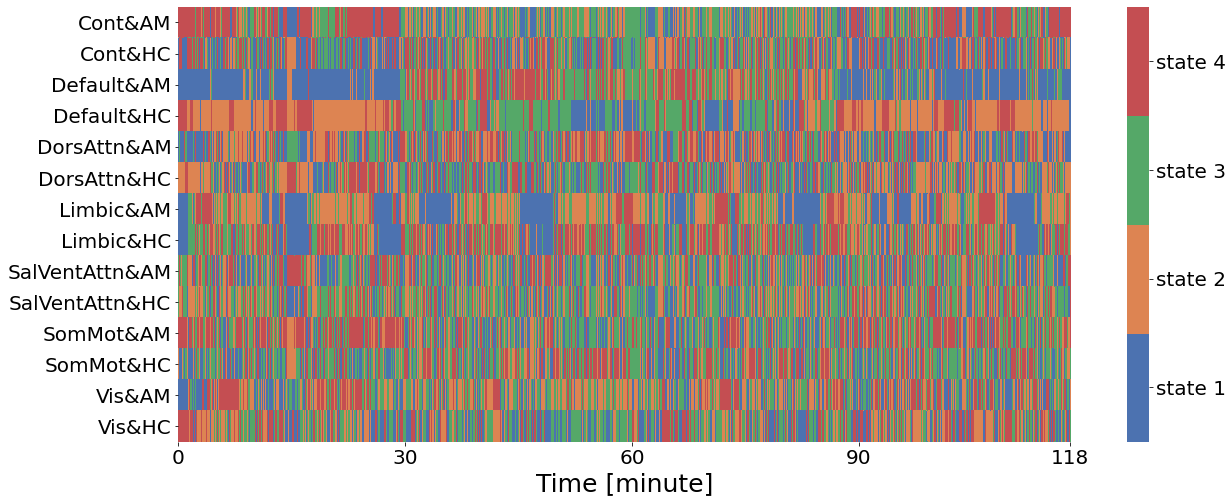

In [38]:
# This just makes some sample 2D data and a corresponding vmap dict with labels for the values in the data
# Fig1b
data = np.array(state_p_matrix)
vmap = {i: 'state '+str(i+1) for i in range(4)}
n = len(vmap)
plt.figure(figsize=(20,8))
cmap = sns.color_palette("deep", n)
ax = sns.heatmap(data, cmap=cmap,yticklabels=yticks,xticklabels=False,)
plt.xlabel('Time [minute]',fontsize=25)
plt.yticks(fontsize=20)
plt.xticks([0, 1800/2,3600/2,5400/2,3540], [0,30,1*60,90,118],fontsize=20)
# plt.title('State Appearance Default_Hippo_sub_nmf200')

# Get the colorbar object from the Seaborn heatmap
colorbar = ax.collections[0].colorbar
# The list comprehension calculates the positions to place the labels to be evenly distributed across the colorbar
r = colorbar.vmax - colorbar.vmin
colorbar.set_ticks([colorbar.vmin + 0.5 * r / (n) + r * i / (n) for i in range(n)])
colorbar.set_ticklabels(list(vmap.values()))
colorbar.ax.tick_params(labelsize=20)
if save_fig:
    plt.savefig('figs/state_presence.png')

## calculate the mean and std for state dwell times


In [43]:
# check the dwell time of each region-network combos
dom_dict = {yticks[i]: data[i,:] for i in range(14)}

df = pd.DataFrame(dom_dict)
keys_list = list(dom_dict.keys())
combo_dt = {}
for col in keys_list:
    tmp = {}
    dts = []
    for i in range(1,5):
        tmp[i] = cal_len(df[col], i)
        dts.append(tmp[i])
    combo_dt[col] = (np.mean(2*np.hstack(dts)), np.std(2*np.hstack(dts)))

combo_dt 

{'Cont&AM': (8.297423887587822, 13.636999124443951),
 'Cont&HC': (4.212841854934601, 4.219300721991753),
 'Default&AM': (11.61639344262295, 20.63874424576079),
 'Default&HC': (25.581227436823106, 33.202987033577),
 'DorsAttn&AM': (7.06480558325025, 7.301428289853508),
 'DorsAttn&HC': (6.430127041742287, 7.300655054903248),
 'Limbic&AM': (9.2870249017038, 20.607934110231604),
 'Limbic&HC': (4.4232209737827715, 8.461304156412615),
 'SalVentAttn&AM': (4.6896095301125085, 4.439566019240441),
 'SalVentAttn&HC': (3.8158319870759287, 3.472254403207279),
 'SomMot&AM': (6.561111111111111, 6.7588054134798075),
 'SomMot&HC': (5.142235123367199, 4.791602014602479),
 'Vis&AM': (9.787292817679559, 9.470749027732813),
 'Vis&HC': (10.065340909090908, 9.299391652740178)}

In [44]:
# check the dwell time of each state
for col in keys_list:
    dts = []
    tmp = {}
    for i in range(1,5):
        tmp[i] = cal_len(df[col], i)
        dts.append(np.mean(tmp[i]))
    print(col, dts)

Cont&AM [4.753521126760563, 2.4233333333333333, 3.4502923976608186, 13.728571428571428]
Cont&HC [1.872495446265938, 3.9285714285714284, 2.4, 1.6064981949458483]
Default&AM [17.17241379310345, 3.8345323741007196, 3.6396396396396398, 4.37037037037037]
Default&HC [8.485294117647058, 15.852272727272727, 14.11111111111111, 11.758620689655173]
DorsAttn&AM [4.43859649122807, 3.3333333333333335, 4.791666666666667, 2.5751445086705202]
DorsAttn&HC [2.696969696969697, 5.973333333333334, 2.2288888888888887, 4.383720930232558]
Limbic&AM [25.377777777777776, 3.9723076923076923, 1.8356940509915014, 11.55]
Limbic&HC [10.037974683544304, 1.2224770642201834, 1.6877394636015326, 2.3646017699115043]
SalVentAttn&AM [2.4074941451990632, 1.6526806526806528, 2.2174840085287846, 4.118279569892473]
SalVentAttn&HC [3.5604395604395602, 1.552677029360967, 2.291731669266771, 1.1582417582417583]
SomMot&AM [2.4927007299270074, 3.6158536585365852, 2.7829268292682925, 4.853448275862069]
SomMot&HC [1.856837606837607, 3.

In [45]:
# calculate the dwell times' variance across different parts of movie
dom_dict = {yticks[i]: data[i,:] for i in range(14)}
df = pd.DataFrame(dom_dict)
keys_list = list(dom_dict.keys())
movie_variance = {}
for col in keys_list:
    dts = [] 
    for j in range(0,3543,500):
        jj = j + 500
        if j == 3000:
            jj = 3543
        if j == 3500:
            break  
        tmp = []
        for i in range(1,5):
            tmp.append(cal_len(df.loc[j:jj,col], i))
        dts.append(2*np.mean(np.hstack(tmp)))
    movie_variance[col] = np.std(dts)
movie_variance

{'Cont&AM': 2.1273527491899142,
 'Cont&HC': 1.0135047951093012,
 'Default&AM': 6.298561831720396,
 'Default&HC': 5.22819601755739,
 'DorsAttn&AM': 0.8202240855675306,
 'DorsAttn&HC': 0.9774701387509316,
 'Limbic&AM': 1.5371170082657606,
 'Limbic&HC': 1.0000233833526218,
 'SalVentAttn&AM': 0.8441081458955214,
 'SalVentAttn&HC': 1.2298848957792081,
 'SomMot&AM': 0.738025459253389,
 'SomMot&HC': 1.52530644643262,
 'Vis&AM': 1.3252361516392979,
 'Vis&HC': 1.6440501661469682}

## Semantics appearance

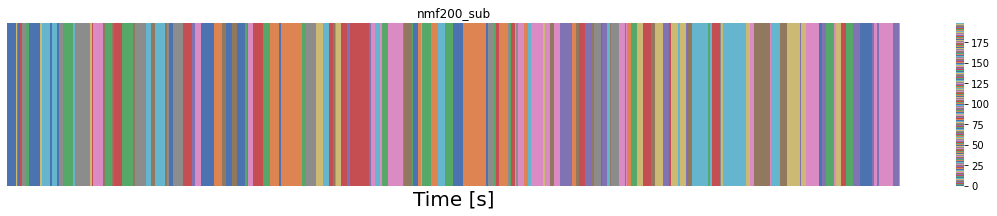

In [46]:
# plot the appearance of embeddings in the categorical way
text = pickle.load(open("{}/text_embeddings_n{}_{}_{}.pickle".format(
        tmp_dir, 200, 'sub', 'nmf'), "rb"))
data = np.argmax(text[240],axis=1).reshape((3543,1)).T
vmap = {i: 'state '+str(i+1) for i in range(200)}
n = len(vmap)
plt.figure(figsize=(20,3))
cmap = sns.color_palette("deep", n)
ax = sns.heatmap(data, cmap=cmap,yticklabels=False,xticklabels=False)
plt.xlabel("Time [s]", fontsize=20 )
plt.title('nmf200_sub')
# Get the colorbar object from the Seaborn heatmap
colorbar = ax.collections[0].colorbar
# The list comprehension calculates the positions to place the labels to be evenly distributed across the colorbar
r = colorbar.vmax - colorbar.vmin
if save_fig:
    plt.savefig('figs/nmf200_sub.png')

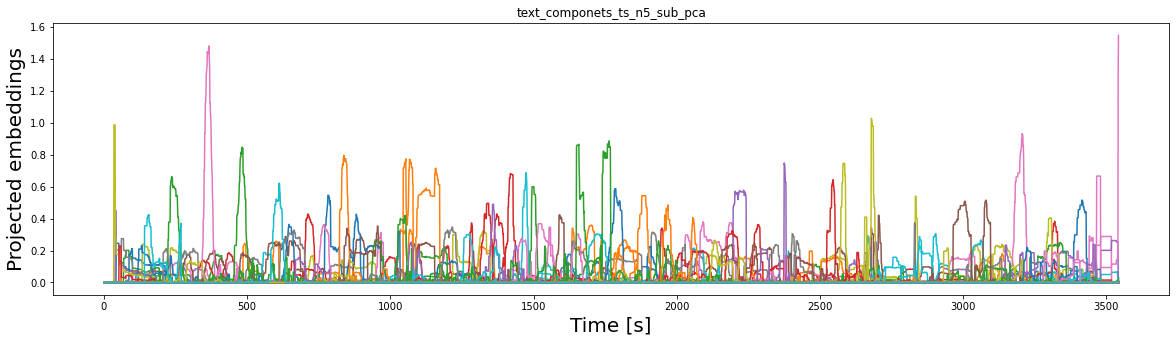

In [47]:
# embeddings of semantic appearance across time
plt.figure(figsize=(20,5))
for i in range(200):
    sns.lineplot(x=range(3543), y=text[240][:,i])
    plt.title("text_componets_ts_n{}_{}{}".format(5, 'sub', '_pca'))
    plt.xlabel("Time [s]", fontsize=20 )
    plt.ylabel("Projected embeddings",fontsize=20 )

## Brain states' pearson's correlations with semantics and annotations

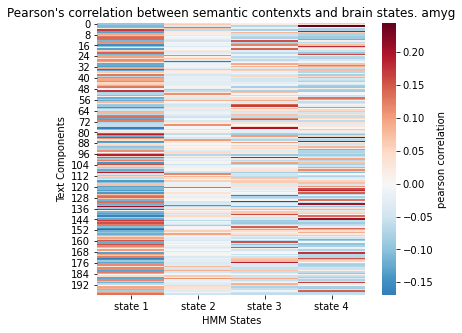

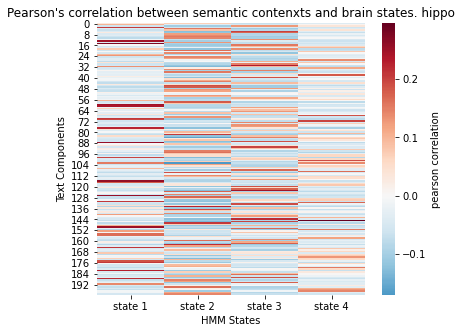

In [48]:
# with semantic contexts
subset = [i for i in sub_dict['01'] if  'n200' in i and 'Default' in i and '_sub' in i]

for k in subset:
    plt.figure(figsize = (6,5))
    sns.heatmap(cort_dict[k][0, ...],cmap='RdBu_r', center = 0,xticklabels=['state ' + str(i+1) for i in range(4)],cbar_kws={'label': 'pearson correlation'})
    plt.xlabel('HMM States')
    plt.ylabel('Text Components')
    plt.title("Pearson's correlation between semantic contenxts and brain states. {}".format(re.findall("amyg|hippo",k)[0]) )
    if save_fig:
        plt.savefig('figs/state_text_cor.png',dpi=300, bbox_inches = "tight")

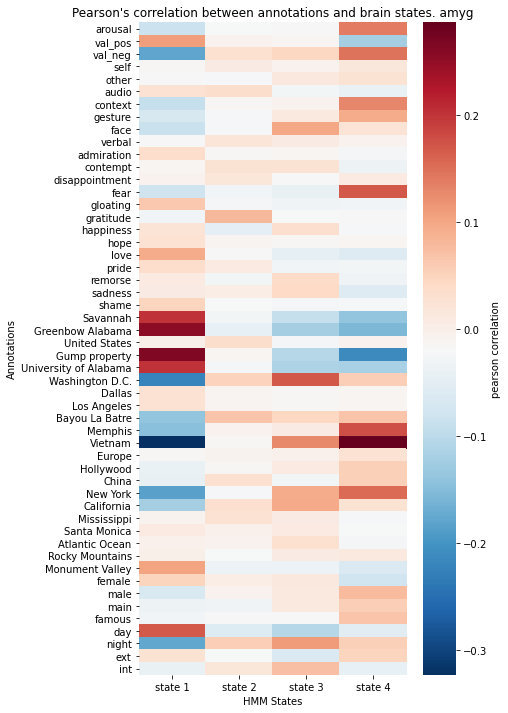

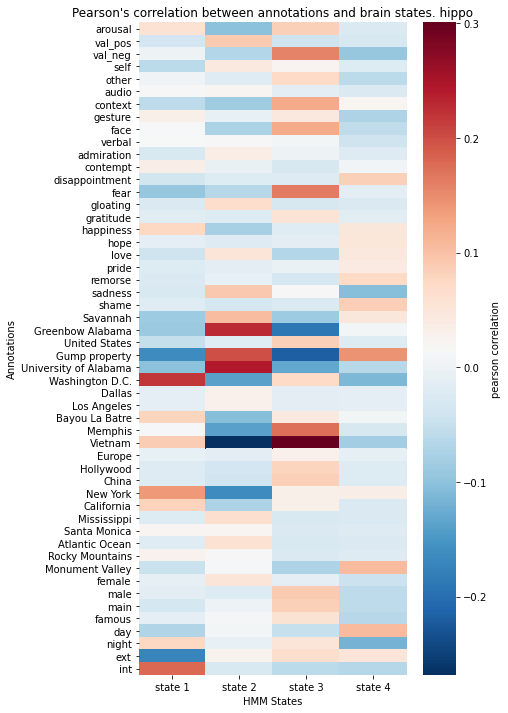

In [49]:
# with annotations
for k in subset:
    plt.figure(figsize=(6, 12))
    sns.heatmap(cora_dict[k],
                yticklabels=np.array(annotations_keys),
                xticklabels=['state ' + str(i + 1) for i in range(4)],
                cmap="RdBu_r",
                cbar_kws={'label': 'pearson correlation'})
    plt.xticks(fontsize=10)
    plt.xlabel('HMM States')
    plt.title("Pearson's correlation between annotations and brain states. {}".format(re.findall("amyg|hippo",k)[0]) )
    plt.ylabel('Annotations')
if save_fig:
    plt.savefig('figs/state_anno_cor.png',dpi=300, bbox_inches = "tight")

# 2. NMF top10


In [51]:
# Focus on default amyg region-network combo since this cell
args_list = [i for i in args_list if 'Default' in i and 'amyg' in i]
k = args_list[0]

Text(0.5, 1.0, 'Correlation_HMMs_final_Default_yeo_amyg_3pcs_n200_4_states_sub_nmf')

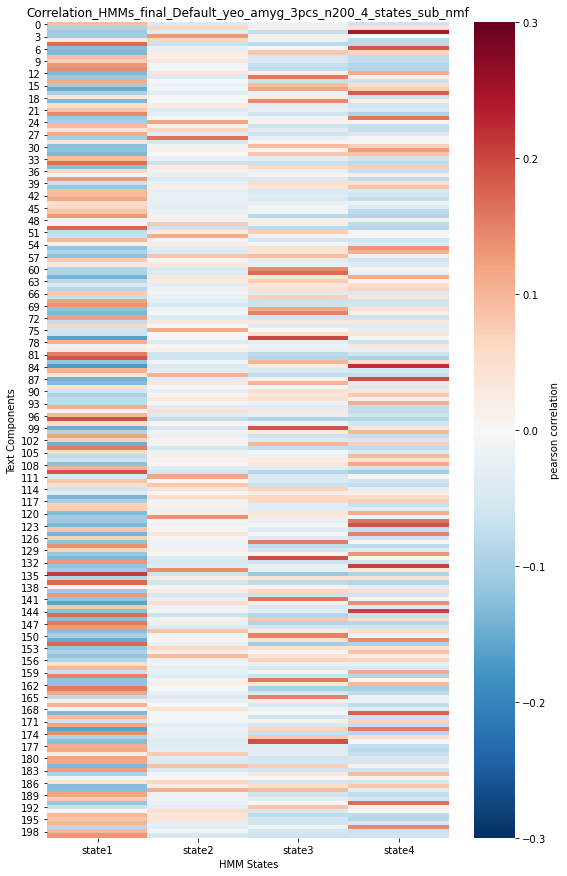

In [52]:
y_ticks = [*c_names_dict[200].values()]
x_ticks = ['state'+str(i) for i in range(1,5)]
plt.figure(figsize = (9,15))
sns.heatmap(cort_dict[k][0, ...],cmap='RdBu_r', center = 0,xticklabels=x_ticks,cbar_kws={'label': 'pearson correlation'},vmax=0.3,vmin=-0.3)
plt.xlabel('HMM States')
plt.ylabel('Text Components')
plt.title('Correlation_'+parse_path(k))

In [53]:
tmp = cort_dict[k][0, ...]
top10 = []
for i in range(4):
    top10.append([(a, b) for a,b in zip(np.argsort(tmp[:,i])[::-1][:10], np.sort(tmp[:,i])[::-1][:10])]) 

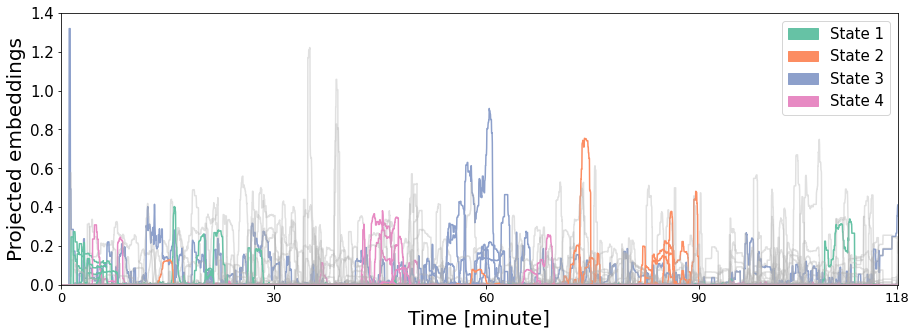

In [54]:
# fig 2B
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
hue = np.zeros([200])
pallet = sns.color_palette("Set2")

for s in range(4)[::-1]:
    for i,j in top10[s]:
        hue[i] = s+1
lsa_embed = np.load(f'{tmp_dir}/lsa_embed_sub_nmf200.npy')
plt.figure(figsize=(15,5))
for i in np.arange(200)[::-1]:
    if hue[i] < 1:
        sns.lineplot(x=range(0, 3543*2, 2), y=lsa_embed[:, i],color=pallet[int(hue[i]-1)],alpha=0.4)
    else:
        sns.lineplot(x=range(0, 3543*2, 2), y=lsa_embed[:, i],color=pallet[int(hue[i]-1)])
handles=[]
for i in range(4):  
    handles.append(mpatches.Patch(color=pallet[i]))
    
plt.legend( loc='upper right', handles=handles, labels=['State 1', 'State 2', 'State 3', 'State 4'],fontsize=15)
plt.xticks(range(0,3543*2,1000),fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel('Time [minute]', fontsize=20)
plt.xlim([0,3543*2])
plt.ylim([0,1.4])

plt.ylabel('Projected embeddings', fontsize=20)
plt.xticks([0, 1800,3600,5400,3540*2], [0,30,1*60,90,118],fontsize=13)
if save_fig:
    plt.savefig('/Users/enningyang/Downloads/hmm_figs/fig2b.png', dpi=600)

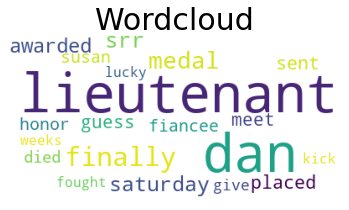

In [55]:
# focus on this sepcial semantic context
plt.figure()
image = img.imread("../text_components2/{}of{}_{}_nmf.png".format(103, 200, 'sub'))
plt.axis('off')
plt.imshow(image)
plt.title('Wordcloud', fontsize = 30)
if save_fig:
    plt.savefig('/Users/enningyang/Downloads/hmm_figs/fig2c.png', dpi=600)

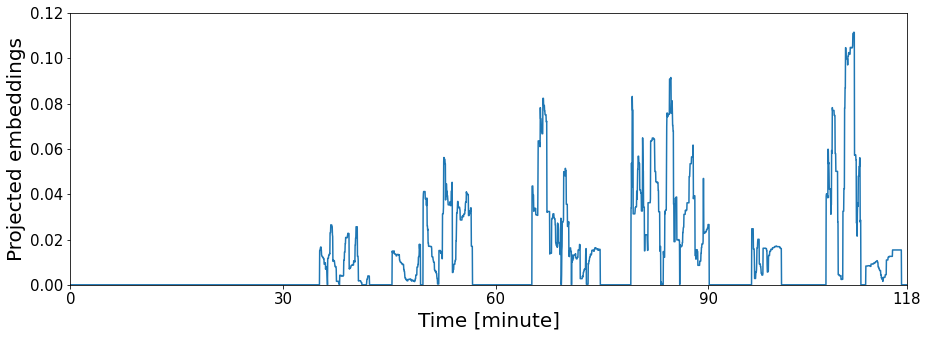

In [56]:
plt.figure(figsize=(15,5))
lsa_embed = np.load(f'{tmp_dir}/lsa_embed_sub_nmf200.npy')

sns.lineplot(x=range(0,3543*2,2), y=lsa_embed[:,103])
plt.xlim([0,3543*2])
plt.ylim([0,0.12])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(fontsize=13)
# plt.axis('off')
plt.xlabel('Time [minute]',fontsize=20)
plt.ylabel('Projected embeddings',fontsize=20)
plt.xticks([0, 1800,3600,5400,3540*2], [0,30,1*60,90,118],fontsize=15)

if save_fig:
    plt.savefig('/Users/enningyang/Downloads/hmm_figs/fig2a.png', dpi=600)

<Figure size 432x288 with 0 Axes>

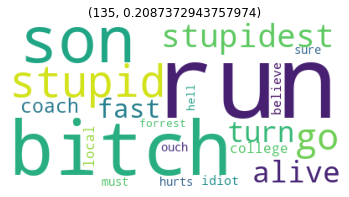

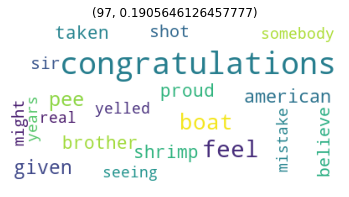

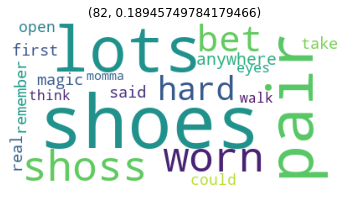

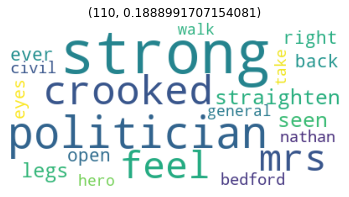

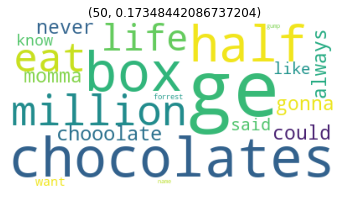

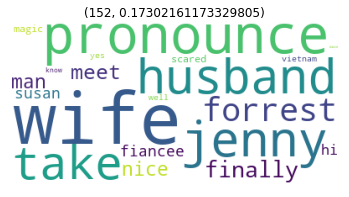

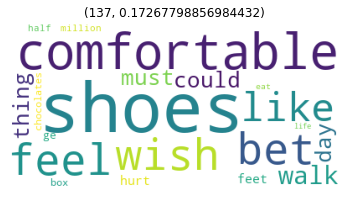

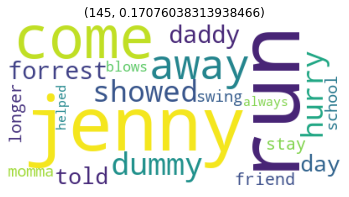

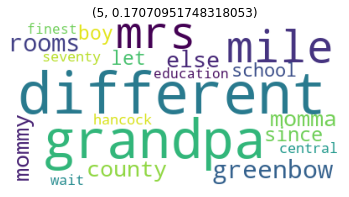

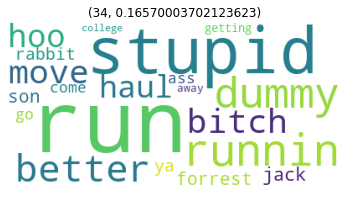

In [57]:
plt.figure()
for i in top10[0]:
    plt.figure()
    image = img.imread("figs/text_components/{}of{}_{}_nmf.png".format(i[0], 200, 'sub'))
    plt.title(i)
    plt.axis('off')
    plt.imshow(image)
# plt.savefig(f"/Users/enningyang/Documents/forrest_project/figs/c103_dan_wc".format(200, opt,tail))

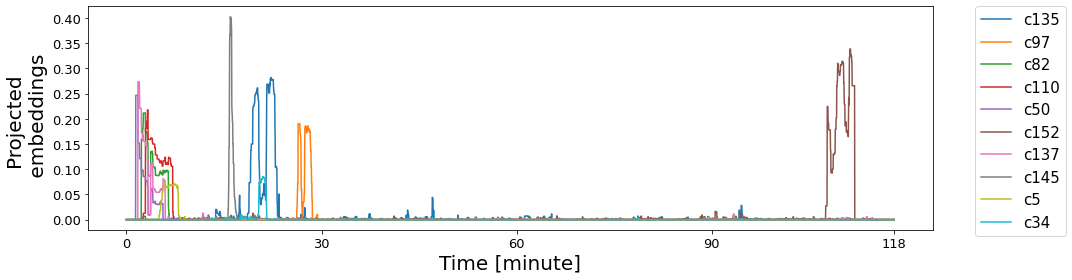

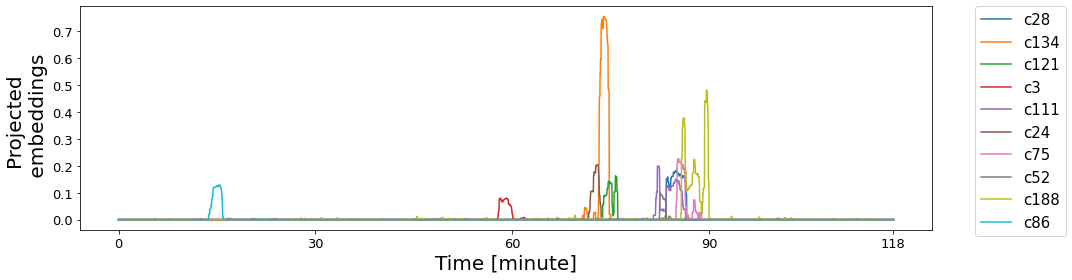

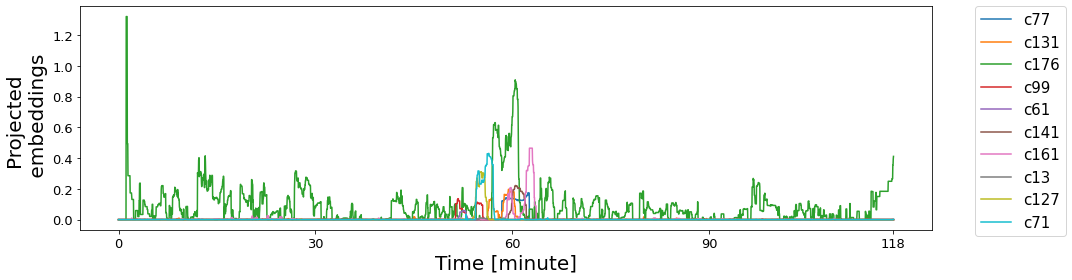

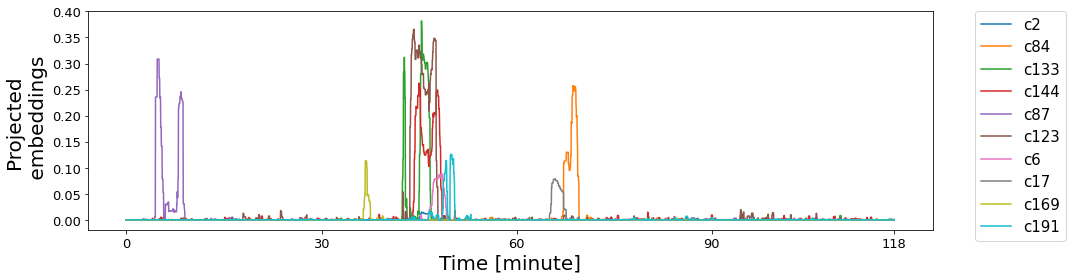

In [58]:
# four states selection of top 10 semantic contexts
import seaborn as sns
import matplotlib.pyplot as plt
c_names = c_names_dict[200]
lsa_embed = np.load(f'{tmp_dir}/lsa_embed_sub_nmf200.npy')
for s in range(4):
    plt.figure(figsize=(15,4))
    top = top10[s]
    for i,j in top:
        j = np.round(j,3)
        ax = sns.lineplot(x=range(3543), y=lsa_embed[:,int(i)],label=f'c{i}')
        

#         plt.title("text_componets_ts_n{}_{}{}_state{}".format(n_components, opt, tail, s+1))
#     plt.legend(loc=(1.04,0))
    #     plt.title("text_componets_ts_n{}_{}{}".format(5, 'sub', '_pca'))
        plt.xlabel("Time [minute]", fontsize=20 )
        plt.xticks([0, 1800/2,3600/2,5400/2,3540], [0,30,1*60,90,118],fontsize=13)

        plt.grid(False)
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        plt.ylabel("Projected \n embeddings",fontsize=20 )
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=15)
        plt.tight_layout()
        if i == 1 and save_fig:
            plt.savefig(f'/Users/enningyang/Downloads/hmm_figs/fig3c1.png',dpi=300, bbox_inches = "tight")


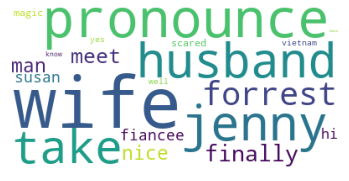

In [59]:
# focus of semantic context 152
plt.figure()
image = img.imread("figs/text_components/{}of{}_{}_nmf.png".format(152, 200, 'sub'))
plt.axis('off')
plt.imshow(image)

In [22]:
lsa_comp = np.load(f'{tmp_dir}/lsa_com_sub_nmf200.npy')
terms = np.load(f'{tmp_dir}/terms.npy')

for s in range(4):
    keywords = []
    key_value = []
    for i,j in top10[s]:
        comp = lsa_comp[i,:]
        termsInComp = zip(terms,comp)
        SortedTerms = sorted(termsInComp, key=lambda x:x[1], reverse=True)[:20]
        keywords.append([i[0] for i in SortedTerms])
        key_value.append([i[1] for i in SortedTerms])
    key_ct = []
    for k in np.unique(keywords):
        ct = 0
        for i,l in enumerate(keywords):
            if k in l:
                ct += key_value[i][l.index(k)]
        key_ct.append((k, np.round(ct,2)))
    SortedKey = sorted(key_ct, key=lambda x:x[1], reverse=True)[:10]


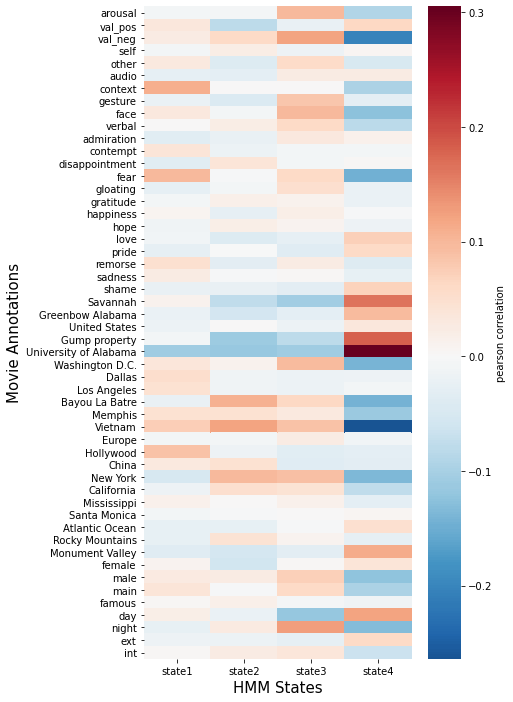

In [60]:
# correlation between movie annotations and hmm states
plt.figure(figsize=(6,12))
sns.heatmap(list(cora_dict.values())[0],cmap='RdBu_r', center = 0, yticklabels=annotations_keys,xticklabels=x_ticks,cbar_kws={'label': 'pearson correlation'})
plt.xlabel('HMM States',fontsize=15)
plt.ylabel('Movie Annotations',fontsize=15)
# plt.title('Correlation')
plt.savefig(f'/Users/enningyang/Downloads/hmm_figs/sup2_annotation.png',dpi=300, bbox_inches = "tight")


<AxesSubplot:>

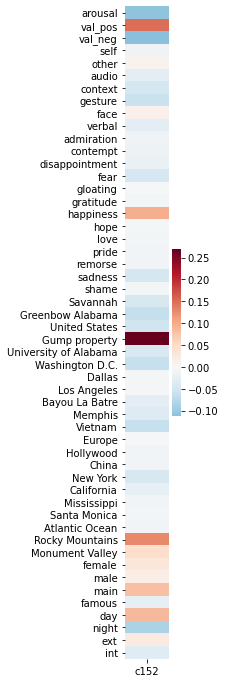

In [62]:
# correlation between annotations and c152 fig3b
lsa_embed = np.load(f'{tmp_dir}/lsa_embed_sub_nmf200.npy')
four = lsa_embed[:,152]

cora = np.zeros([1,52])
for i in range(1):
    for j in range(52):
        cora[i,j] = pearsonr(four[:], annotations[annotations_keys[j]])[0]
plt.figure(figsize=(1,12))

sns.heatmap(cora.T, cmap='RdBu_r',yticklabels=annotations_keys, xticklabels=['c152'],center=0)


### Annotations

In [63]:
k = main_compare
state_p_dict[k].shape
top_idx = np.argmax((cora_dict[k]),axis=0)
for s,i in enumerate(top_idx):
    print(cora_dict[k][i,s], annotations_keys[i])

0.10967291871786804 context
0.12115047225340804 Vietnam
0.12664204815333402 night
0.30513249107068724 University of Alabama


# Brain patterns


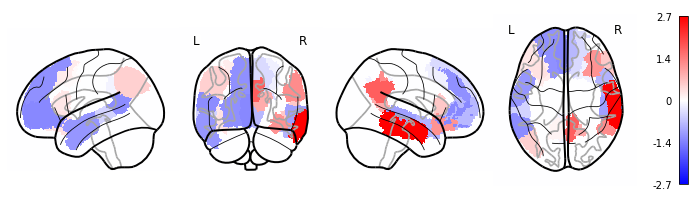

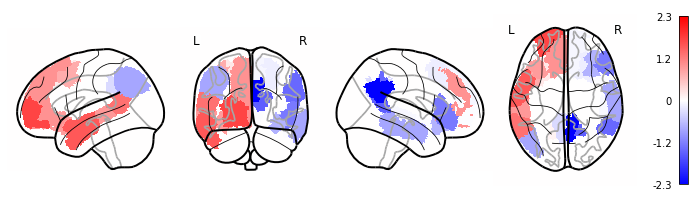

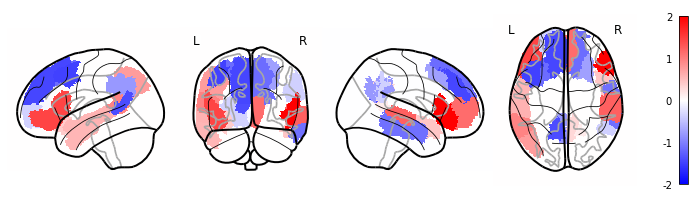

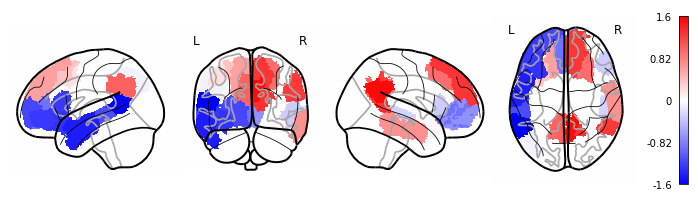

In [29]:
# the glass brain plots of four states
labels_strings = []
schaefer = nilearn.datasets.fetch_atlas_schaefer_2018(n_rois=100,
                                                yeo_networks=7)
for label in schaefer.labels:
    labels_strings.append(label.decode('utf-8'))
xticks = [
    i.replace('7Networks_', '') for i in labels_strings if 'Default' in i
]

dmn_idx =  [i for i, s in enumerate(labels_strings) if 'Default' in s]
brains = []
for i in range(4):

    schaefer_rois = np.array(schaefer.labels, dtype=str)
    schaefer_atlas = schaefer.maps
    masker = NiftiLabelsMasker(labels_img=schaefer_atlas, standardize=False,
                                    memory='nilearn_cache').fit()
    data = np.zeros(100)
    data[dmn_idx] = zscore(HMMs_dict[k].means_[i,:24]).reshape((-1))
    data = np.reshape(data, (-1, 1))
    nifti = masker.inverse_transform(data.T)
    brains.append(nifti)
    ax = plotting.plot_glass_brain(nifti, threshold=None, colorbar=True,
                                  plot_abs=False, black_bg=False, cmap='bwr',
                                  symmetric_cbar=True, alpha=1,display_mode='lyrz')
#     plt.legend(ax, fontsize=15, title='z')
    if save_fig:
        plt.savefig(f'/Users/enningyang/Downloads/hmm_figs/sup1_state{i}.png',dpi=300, bbox_inches = "tight")
    plt.show()

## Covariance 

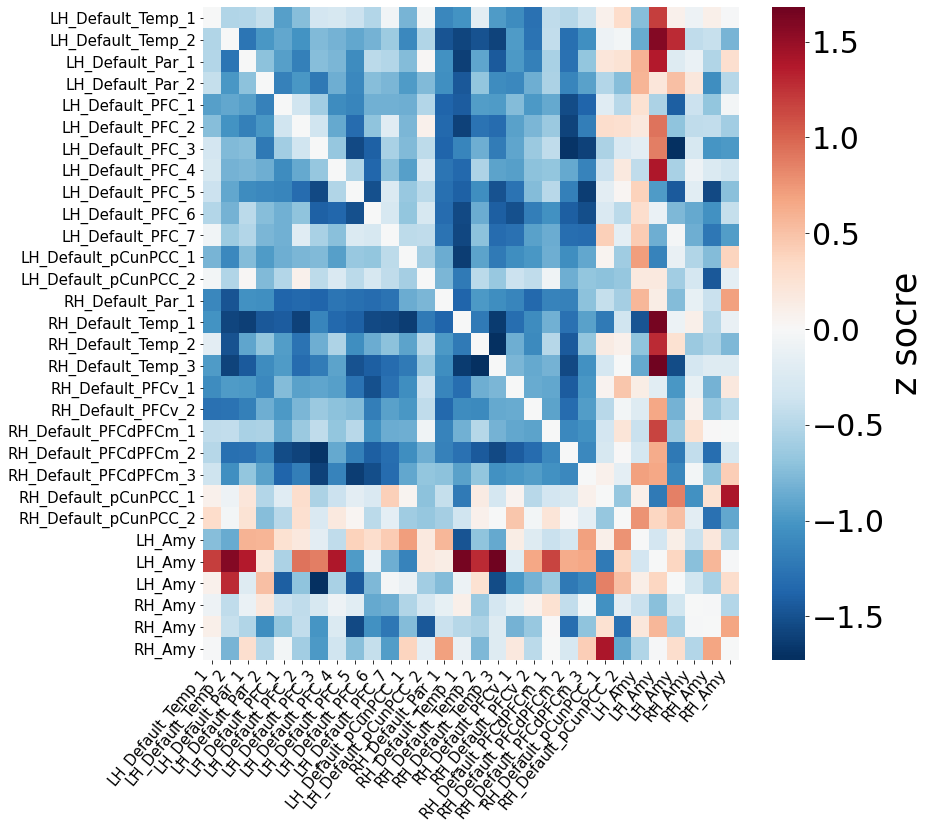

In [30]:
plt.figure(figsize=(12, 12))
k = [i for i in subset if 'amyg' in i][0]
xticks = get_xticks(k)
xticks = [i.replace('amyg','Amy').replace('left','LH').replace('right', 'RH') for i in xticks]
v = HMMs_dict[k]   # Zscore
mean = zscore(v.covars_)
np.fill_diagonal(mean[0], 0)
ax = sns.heatmap(mean[0],
            cmap="RdBu_r",
            center=0,
            xticklabels=xticks,
            yticklabels=xticks,
           cbar_kws={'label':'zscore'})
plt.xticks(fontsize=15,rotation=50,ha='right')
plt.yticks(fontsize=15)
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=30)
ax.figure.axes[-1].set_ylabel('z socre', size=35)


plt.show()

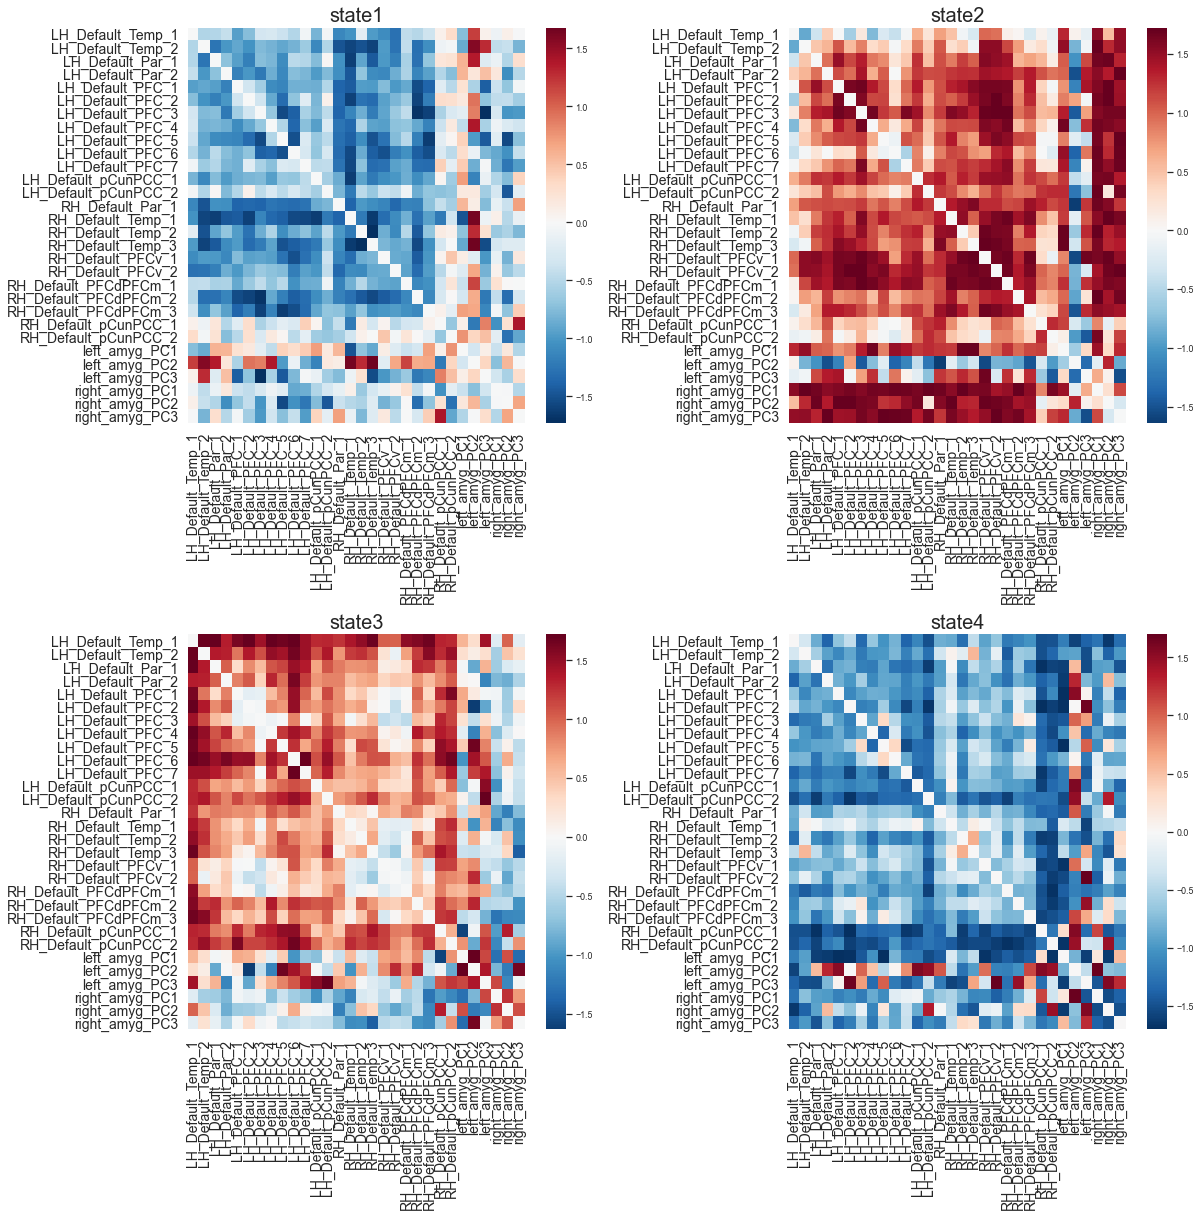

In [32]:
sns.set(font_scale=0.8)
for i, k in enumerate(subset):

    xticks = get_xticks(k)
    for i in range(1,4):
        xticks[-4+i] = 'right_amyg_PC' + str(i)
        xticks[-7+i] ='left_amyg_PC' + str(i)
    v = HMMs_dict[k]   # Zscore
    mean = zscore(v.covars_)
    nstates = mean.shape[0]
    fig, axs = plt.subplots(ncols=2 , nrows=int(nstates/2), figsize=(17, 17))
    plt.subplots_adjust(left=None,
                        bottom=None,
                        right=None,
                        top=None,
                        wspace=.5,
                        hspace=.5)
#     plt.suptitle(parse_path(k))
    for i,j in enumerate(range(4)):
        xx = i // 2
        yy = i % 2
        np.fill_diagonal(mean[j], 0)
        sns.heatmap(mean[i],
                    ax=axs[xx, yy],
                    cmap="RdBu_r",
                    center=0,
                    xticklabels=xticks,
                    yticklabels=xticks)
        axs[xx,yy].tick_params(axis='both', which='major', labelsize=14)
        axs[xx, yy].set_title(f'state{i+1}',fontsize=20)# TODO x labels
plt.tight_layout()
if save_fig:
    plt.savefig(f'/Users/enningyang/Downloads/hmm_figs/supn_covar.png',dpi=300, bbox_inches = "tight")


## Extra region

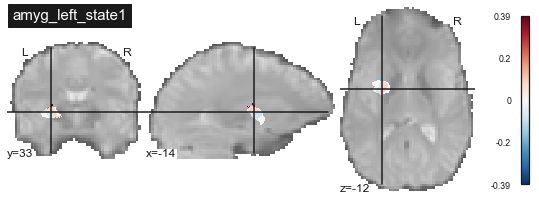

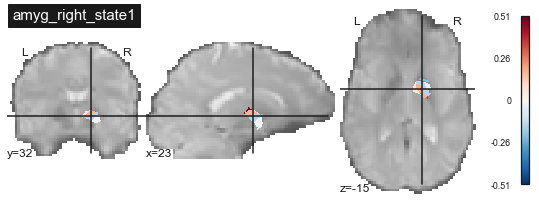

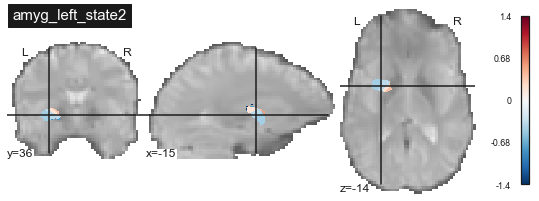

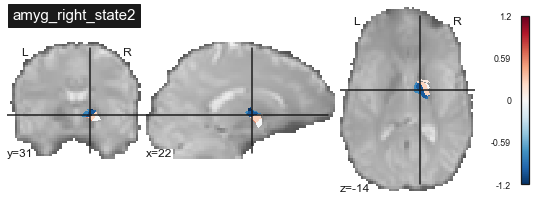

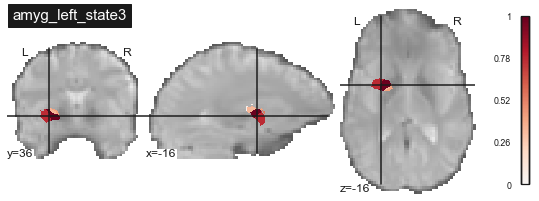

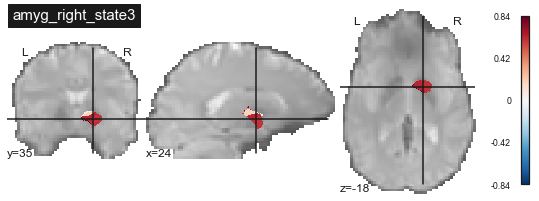

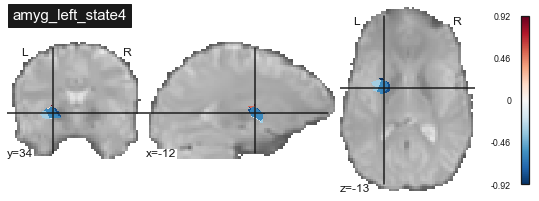

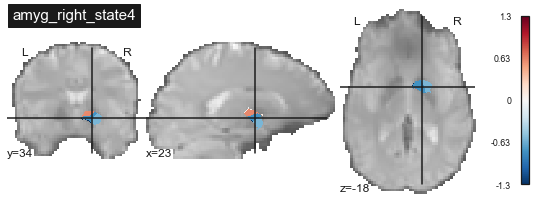

In [33]:
hmm = HMMs_dict[k]
nac_type = re.findall("(nac|hippo|amyg|all)", k)[0]
xticks = get_xticks(k)
states = hmm.means_
hippo_pca = np.load(f"{tmp_dir}/hippo_pca.npy", allow_pickle=True).item()
amyg_pca = np.load(f"{tmp_dir}/amyg_pca.npy", allow_pickle=True).item()
nac_pca = np.load(f"{tmp_dir}/nac_pca.npy", allow_pickle=True).item()
pca_dict = {'hippo': hippo_pca, 'amyg': amyg_pca, 'nac': nac_pca}

def prepare_masks():
    right_hippoAma = nilearn.image.load_img(
        f'{tmp_dir}/sub01_rh.nii.gz'
    )
    left_hippoAma = nilearn.image.load_img(
        f'{tmp_dir}/sub01_lh.nii.gz'
    )

    right_hippoAma_data = nilearn.image.get_data(right_hippoAma)
    right_hippoAma_data = np.around(right_hippoAma_data).astype(int)
    right_hippo_data = right_hippoAma_data.copy()
    right_amyg_data = right_hippoAma_data.copy()
    right_hippo_data[right_hippo_data > 7000] = 0
    right_amyg_data[right_amyg_data < 7000] = 0

    left_hippoAma_data = nilearn.image.get_data(left_hippoAma)
    left_hippoAma_data = np.around(left_hippoAma_data).astype(int)
    left_hippo_data = left_hippoAma_data.copy()
    left_amyg_data = left_hippoAma_data.copy()
    left_hippo_data[left_hippo_data > 7000] = 0
    left_amyg_data[left_amyg_data < 7000] = 0

    left_hippo_maps = nibabel.nifti1.Nifti1Image(left_hippo_data,
                                                 affine=left_hippoAma.affine)
    right_hippo_maps = nibabel.nifti1.Nifti1Image(right_hippo_data,
                                                  affine=right_hippoAma.affine)
    left_amyg_maps = nibabel.nifti1.Nifti1Image(left_amyg_data,
                                                affine=left_hippoAma.affine)
    right_amyg_maps = nibabel.nifti1.Nifti1Image(right_amyg_data,
                                                 affine=right_hippoAma.affine)

    lh_masker = NiftiLabelsMasker(labels_img=left_hippo_maps,
                                  standardize=True,
                                  memory='nilearn_cache').fit()
    rh_masker = NiftiLabelsMasker(labels_img=right_hippo_maps,
                                  standardize=True,
                                  memory='nilearn_cache').fit()
    la_masker = NiftiLabelsMasker(labels_img=left_amyg_maps,
                                  standardize=True,
                                  memory='nilearn_cache').fit()
    ra_masker = NiftiLabelsMasker(labels_img=right_amyg_maps,
                                  standardize=True,
                                  memory='nilearn_cache').fit()
    ln_masker = np.load(f'{tmp_dir}/lh_masker.npy', allow_pickle=1).item().fit()
    rn_masker = np.load(f'{tmp_dir}/rh_masker.npy', allow_pickle=1).item().fit()

    masker_dict = {
        "nac": [ln_masker, rn_masker],
        "hippo": [lh_masker, rh_masker],
        "amyg": [la_masker, ra_masker]
    }
    return masker_dict


masker_dict = prepare_masks()
pca = pca_dict[nac_type]
left, right = masker_dict[nac_type]
rmv = int(n_pcs_dict[nac_type] / 2)
states_in = zscore(states)
for i in range(4):
    state = states_in[i, :]
    tmp = pca.inverse_transform(state[-2 * rmv:-rmv])
    tmp = np.reshape(tmp, (1, -1))
    tmp = left.inverse_transform(tmp)
    tmp.to_filename(
        f"{tmp_dir}/{parse_path(k)}_left_state{i+1}.nii.gz")
    plotting.plot_stat_map(
        tmp,
        f'{tmp_dir}/brain.nii.gz',
        cmap='RdBu_r',
#         display_mode='x',
        black_bg=0,
#         cut_coords=1,
        resampling_interpolation='nearest',
        title=f"{nac_type}_left_state{i+1}")

    tmp = pca.inverse_transform(state[-rmv:])
    tmp = np.reshape(tmp, (1, -1))
    tmp = right.inverse_transform(tmp)
    tmp.to_filename(
        f"{tmp_dir}/{parse_path(k)}_right_state{i+1}.nii.gz")
    plotting.plot_stat_map(
        tmp,
        f'{tmp_dir}/brain.nii.gz',
        cmap='RdBu_r',
#         display_mode='x',
#         cut_coords=1,
        black_bg=0,
        resampling_interpolation='nearest',
        title=f"{nac_type}_right_state{i+1}")

In [34]:
left_data = []
right_data = []
for i in range(4):
    state = states_in[i, :]
    left_data.append(pca.inverse_transform(state[-2 * rmv:-rmv]))
    right_data.append(pca.inverse_transform(state[-rmv:]))
com = zscore(np.hstack([left_data,right_data]))
left_data = com[:,:9]
right_data = com[:,9:]

Text(31.499999999999993, 0.5, 'amygdala subregion')

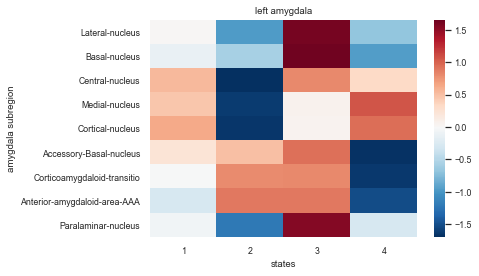

In [35]:
haNames = list(np.load(f'{tmp_dir}/hippoAmygNames.npy'))
hippoNames = haNames[19:]
sns.heatmap(np.array(left_data).T, cmap='RdBu_r', center=0, yticklabels=hippoNames, xticklabels=range(1, 5))
plt.title('left amygdala')
plt.xlabel('states')
plt.ylabel('amygdala subregion')

Text(31.499999999999993, 0.5, 'amygdala subregion')

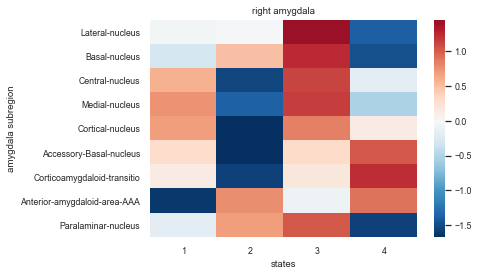

In [36]:
haNames = list(np.load(f'{tmp_dir}/hippoAmygNames.npy'))
hippoNames = haNames[19:]
sns.heatmap(np.array(right_data).T, cmap='RdBu_r', center=0, yticklabels=hippoNames, xticklabels=range(1, 5))
plt.title('right amygdala')
plt.xlabel('states')
plt.ylabel('amygdala subregion')

In [38]:
haNames = list(np.load(f'{tmp_dir}/hippoAmygNames.npy'))
amygNames = haNames[19:]

amygName_short = ['LA','BA','CeA','MeA', 'CoA', 'BM', 'CxA', 'AAA', 'PL']
np.save(f'{tmp_dir}/amygName_short.npy',amygName_short)

In [39]:
df = pd.DataFrame({
    'data':np.hstack([left_data[0],right_data[0]]).reshape(-1),
    'hemi':np.hstack([['l']*9,['r']*9]),
    'pos': np.hstack([left_data[0,:],right_data[0,:]]).reshape(-1)>0,
    'name':amygName_short*2
})

In [40]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import pandas as pd
tight = go.layout.Margin(
        l=0, #left margin
        r=0, #right margin
        b=0, #bottom margin
        t=0, #top margin
    )
categories = amygName_short
layout = go.Layout(
  margin=go.layout.Margin(
        l=0, #left margin
        r=0, #right margin
        b=0, #bottom margin
        t=0, #top margin
    )
)
fig = make_subplots(rows=2, cols=1,specs=[[{'type': 'polar'}]*1]*2,row_titles=['left','right'],horizontal_spacing = 0.1,
                    vertical_spacing = 0.1)

for i in range(1):
    fig.add_trace(go.Scatterpolar(
          r=left_data[i].clip(min=0),
          theta=categories,
          fill='toself',fillcolor='orangered',line_color='red',dr=0.5,
          name='Pos',showlegend=not(i),opacity=0.7
    ),row=i+1,col=1)
    fig.add_trace(go.Scatterpolar(
          r=np.abs(left_data[i].clip(max=0)),
          theta=categories,
          fill='toself',fillcolor='lightblue',line_color='blue',dr=0.5,
          name='Neg',showlegend=not(i),opacity=0.7

    ),row=i+1,col=1)

    fig.add_trace(go.Scatterpolar(
          r=right_data[i].clip(min=0),
          theta=categories,
          fill='toself',fillcolor='orangered',line_color='red',dr=0.5,
          name='Pos',showlegend=False,opacity=0.7

    ),    row=i+2,col=1)
    fig.add_trace(go.Scatterpolar(
          r=np.abs(right_data[i].clip(max=0)),
          theta=categories,
          fill='toself',fillcolor='lightblue',line_color='blue',dr=0.5,
          name='Neg',showlegend=False,opacity=0.7
            ),row=i+2,col=1)


fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
    )),
  showlegend=True,
height=500, width=400, margin=go.layout.Margin(
        l=0, #left margin
        r=0, #right margin
        b=20, #bottom margin
        t=20, #top margin
    ),title_x=0.5
    

)

In [41]:
fig = make_subplots(rows=4, cols=2,specs=[[{'type': 'polar'}]*2]*4,
                    row_titles=['State1','State2', 'State3','State4'],horizontal_spacing = 0,
                    vertical_spacing = 0.05)

for i in range(4):
    fig.add_trace(go.Scatterpolar(
          r=left_data[i].clip(min=0),
          theta=categories,
          fill='toself',fillcolor='orangered',line_color='red',dr=0.5,
          name='Pos',showlegend=not(i),opacity=0.7
    ),row=i+1,col=1)
    fig.add_trace(go.Scatterpolar(
          r=np.abs(left_data[i].clip(max=0)),
          theta=categories,
          fill='toself',fillcolor='lightblue',line_color='blue',dr=0.5,
          name='Neg',showlegend=not(i),opacity=0.7

    ),row=i+1,col=1)

    fig.add_trace(go.Scatterpolar(
          r=right_data[i].clip(min=0),
          theta=categories,
          fill='toself',fillcolor='orangered',line_color='red',dr=0.5,
          name='Pos',showlegend=False,opacity=0.7

    ),    row=i+1,col=2)
    fig.add_trace(go.Scatterpolar(
          r=np.abs(right_data[i].clip(max=0)),
          theta=categories,
          fill='toself',fillcolor='lightblue',line_color='blue',dr=0.5,
          name='Neg',showlegend=False,opacity=0.7
            ),row=i+1,col=2)


fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
    )),
  showlegend=True,
height=1200, width=800, margin=go.layout.Margin(
        l=0, #left margin
        r=0, #right margin
        b=0, #bottom margin
        t=50, #top margin
    ),title='Contribution of Each Subregion',title_x=0.5
    

)